# Generate Flood Maps without downloading OPERA DSWx-HLS products locally
## This tutorial demonstrates how to query and work with the OPERA DSWx-HLS Provisional Data products from the cloud ([OPERA_L3_DSWX-HLS_PROVISIONAL_V1](https://dx.doi.org/10.5067/OPDSW-PL3V1)).

---    

### Data Used in the Example:   

- **30 meter (m) global OPERA Dynamic Surface Water Extent from Harmonized Landsat Sentinel-2 provisional product (Version 1) - [OPERA_L3_DSWX-HLS_PROVISIONAL_V1](https://dx.doi.org/10.5067/OPDSW-PL3V1)**
    - This dataset contains Level-3 Dynamic OPERA provisional surface water extent product version 1.  The data are provisional  surface water extent observations beginning April 2023. Known issues and caveats on usage are described under Documentation. The input dataset for generating each product is the Harmonized Landsat-8 and Sentinel-2A/B (HLS) product version 2.0. HLS products provide surface reflectance (SR) data from the Operational Land Imager (OLI) aboard the Landsat 8 satellite and the MultiSpectral Instrument (MSI) aboard the Sentinel-2A/B satellite. The surface water extent products are distributed over projected map coordinates using the Universal Transverse Mercator (UTM) projection. Each UTM tile covers an area of 109.8 km × 109.8 km. This area is divided into 3,660 rows and 3,660 columns at 30-m pixel spacing. Each product is distributed as a set of 10 GeoTIFF (Geographic Tagged Image File Format) files including water classification, associated confidence, land cover classification, terrain shadow layer, cloud/cloud-shadow classification, Digital elevation model (DEM), and Diagnostic layer.
     - **Science Dataset (SDS) layers: Florida Floods**
        - B02_BWTR (Binary Water Layer)  
        - B03_CONF (Confidence Layer)  

Please refer to the [OPERA Product Specification Document](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DSWX_URS309746.pdf) for details about the DSWx-HLS product.

---

## Before Starting this Tutorial  

A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.

---
## 1. Getting Started <a id="getstarted"></a>

### 1.1 Import Packages <a id="1.1"></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

from pystac_client import Client  
from pystac_client import ItemSearch

import json

import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from tqdm import tqdm

from shapely.geometry import box
from shapely.geometry import shape
from shapely.ops import transform

import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io

from osgeo import gdal
from rioxarray.merge import merge_arrays

import pyproj
from pyproj import Proj

import folium
from folium import plugins
import geoviews as gv
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

import sys
sys.path.append('../../')
from src.dswx_utils import intersection_percent, colorize, getbasemaps, transform_data_for_folium

import warnings
warnings.filterwarnings('ignore')

### 1.2 Set up Working Environment <a id="1.2"></a>

In [3]:
inDir = os.getcwd()
os.chdir(inDir)

### 1.3 Generate Authentication Token <a id="1.3"></a>

In [4]:
# Generates authentication token
# Asks for your Earthdata username and password for first time, if netrc does not exists in your home directory.

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [5]:
# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'YES')

# export CPL_VSIL_CURL_USE_HEAD=YES
# export GDAL_DISABLE_READDIR_ON_OPEN=OPEN_DIR
# export GDAL_HTTP_COOKIEJAR=/tmp/cookies.txt
# export GDAL_HTTP_COOKIEFILE=/tmp/cookies.txt
# export CPL_VSIL_CURL_ALLOWED_EXTENSIONS=TIF

## 2. CMR-STAC API: Search for data based on spatial query <a id="searchstac"></a>

### 2.1 Initialize user-defined parameters <a id="2.1"></a>

In [6]:
# USER-DEFINED PARAMETERS
aoi = box(-84.51563, 27.82194, -82.10303, 30.48091) #box(67.4, 26.2, 68.0, 27.5)
start_date = datetime(2023, 8, 1)                                       # in 2022-01-01 00:00:00 format
stop_date = f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"         # in 2022-01-01 00:00:00 format
overlap_threshold = 10                                                  # in percent
#cloud_cover_threshold = 20                                             # in percent

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2023-08-01 00:00:00 and 2023-09-13 23:59:59
With AOI: {'type': 'Polygon', 'coordinates': (((-82.10303, 27.82194), (-82.10303, 30.48091), (-84.51563, 30.48091), (-84.51563, 27.82194), (-82.10303, 27.82194)),)}


In [7]:
# Search data through CMR-STAC API
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/POCLOUD/')
collections = ['OPERA_L3_DSWX-HLS_PROVISIONAL_V1']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "max_items": 1000}
search_dswx = api.search(**search_params)

### 2.2 Query DSWx-HLS tiles based on spatial overlap with respect to defined AOI <a id="2.2"></a>

In [8]:
# Filter datasets based on spatial overlap 
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_dswx.items()])

# Apply spatial overlap and cloud cover filter
dswx_filtered = (
    i for i in search_dswx.items() if (intersection_percent(i, intersects_geometry) > overlap_threshold)
)

Percent overlap before filtering: 
['10.27', '15.15', '18.20', '4.20', '8.08', '11.41', '11.41', '8.08', '10.27', '12.50', '8.08', '15.15', '18.20', '11.41', '14.85', '4.20', '18.20', '12.50', '10.27', '15.15', '4.20', '14.85', '10.27', '15.15', '18.20', '14.85', '4.20', '10.27', '12.50', '8.08', '15.15', '18.20', '11.41', '14.85', '4.20', '10.27', '15.15', '18.20', '14.85', '4.20', '11.41', '8.08', '18.20', '12.50', '10.27', '8.08', '11.41', '10.27', '15.15', '14.85', '4.20', '10.27', '12.50', '8.08', '15.15', '18.20', '11.41', '14.85', '10.27', '15.15', '18.20', '4.20', '11.41', '8.08', '10.27', '12.50', '8.08', '15.15', '18.20', '11.41', '14.85', '10.27', '8.08', '11.41', '10.27', '12.50', '8.08', '15.15', '18.20', '11.41', '14.85', '4.20', '10.27', '15.15', '18.20', '14.85', '4.20', '8.08', '11.41', '11.41', '12.50', '10.27', '8.08', '18.20', '10.27', '12.50', '8.08', '18.20', '14.85', '4.20', '14.85', '10.27', '15.15', '18.20', '14.85', '4.20', '10.27', '12.50', '8.08', '15.15', '

In [9]:
# Inspect the items inside the filtered query
dswx_data = list(dswx_filtered)
# Inspect one data
dswx_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'OPERA_L3_DSWx-HLS_T17RLP_20230801T155829Z_20230804T014434Z_S2B_30_v1.0',
 'properties': {'datetime': '2023-08-01T16:15:08.497000Z',
  'start_datetime': '2023-08-01T16:15:08.497Z',
  'end_datetime': '2023-08-01T16:15:08.497Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-83.091, 29.814],
    [-81.934, 29.814],
    [-81.934, 30.818],
    [-83.091, 30.818],
    [-83.091, 29.814]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/POCLOUD/collections/OPERA_L3_DSWX-HLS_PROVISIONAL_V1.v1.0/items/OPERA_L3_DSWx-HLS_T17RLP_20230801T155829Z_20230804T014434Z_S2B_30_v1.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/POCLOUD/collections/OPERA_L3_DSWX-HLS_PROVISIONAL_V1.v1.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/POCLOUD/collections/OPERA_L3_DSWX-HLS_PROVISIONAL_V1.v1.0'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://cmr.earth

In [10]:
## Print search information
# Tota granules
print(f"Total granules after search filter: {len(dswx_data)}")

#Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dswx_data])

# # Check percent cloud cover values
# print("\nPercent cloud cover before filtering: ")
# print([f"{i.properties['eo:cloud_cover']}" for i in search_dswx.items()])

Total granules after search filter: 107
Percent-overlap: 
['10.27', '15.15', '18.20', '11.41', '11.41', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '18.20', '12.50', '10.27', '15.15', '14.85', '10.27', '15.15', '18.20', '14.85', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '10.27', '15.15', '18.20', '14.85', '11.41', '18.20', '12.50', '10.27', '11.41', '10.27', '15.15', '14.85', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '10.27', '15.15', '18.20', '11.41', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '10.27', '11.41', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '10.27', '15.15', '18.20', '14.85', '11.41', '11.41', '12.50', '10.27', '18.20', '10.27', '12.50', '18.20', '14.85', '14.85', '10.27', '15.15', '18.20', '14.85', '10.27', '12.50', '15.15', '18.20', '11.41', '14.85', '11.41', '10.27', '15.15', '18.20', '14.85', '18.20', '10.27', '12.50', '15.15', '14.85', '11.41', '10.27', '12.50', '18.20', '11.41', '14.85', '10.27', '15.15', '18.2

In [11]:
# Visualize the DSWx tile boundary and the user-defined bbox
geom_df = []
for d,_ in enumerate(dswx_data):
    geom_df.append(shape(dswx_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})
granules_poly = gv.Polygons(geom_granules, label='DSWx tile boundary').opts(line_color='blue', color=None, show_legend=True)

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=1000, height=1000)

# Get the user-specified aoi
geom_aoi = shape(intersects_geometry)
aoi_poly = gv.Polygons(geom_aoi, label='User-specified bbox').opts(line_color='yellow', color=None, show_legend=True)

# Plot using geoviews wrapper
granules_poly*base*aoi_poly

:Overlay
   .Polygons.DSWx_tile_boundary               :Polygons   [Longitude,Latitude]
   .WMTS.I                                    :WMTS   [Longitude,Latitude]
   .Polygons.User_hyphen_minus_specified_bbox :Polygons   [Longitude,Latitude]

### 2.3 Create a table of search results <a id="2.3"></a>

In [12]:
# Create table of search results
dswx_data_df = []
for item in dswx_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    sensor = fn[6]
    dat = item.datetime.strftime('%Y-%m-%d')
    spatial_overlap = intersection_percent(item, intersects_geometry)
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    #dswx_data_df.append([ID,sensor,dat,geom,bbox,spatial_overlap,cloud_cover,band_links])
    dswx_data_df.append([ID,sensor,dat,geom,bbox,spatial_overlap,band_links])


dswx_data_df = pd.DataFrame(dswx_data_df, columns = ['TileID', 'Sensor', 'Date', 'Coords', 'bbox', 'SpatialOverlap', 'BandLinks'])
dswx_data_df

TileID Sensor        Date  \
0    T17RLP    S2B  2023-08-01   
1    T17RLN    S2B  2023-08-01   
2    T17RKN    S2B  2023-08-01   
3    T16RGT    S2A  2023-08-02   
4    T16RGT     L8  2023-08-03   
..      ...    ...         ...   
102  T17RLP    S2B  2023-09-10   
103  T17RLN    S2B  2023-09-10   
104  T17RKN    S2B  2023-09-10   
105  T17RLM    S2B  2023-09-10   
106  T16RGT    S2A  2023-09-11   

                                                Coords  \
0    {'type': 'Polygon', 'coordinates': [[[-83.091,...   
1    {'type': 'Polygon', 'coordinates': [[[-83.071,...   
2    {'type': 'Polygon', 'coordinates': [[[-84.106,...   
3    {'type': 'Polygon', 'coordinates': [[[-84.949,...   
4    {'type': 'Polygon', 'coordinates': [[[-84.949,...   
..                                                 ...   
102  {'type': 'Polygon', 'coordinates': [[[-83.091,...   
103  {'type': 'Polygon', 'coordinates': [[[-83.071,...   
104  {'type': 'Polygon', 'coordinates': [[[-84.106,...   
105  {'type': 'Polygon', 'coordinates': [[[-83.053,...   
106  {'type': 'Polygon', 'coordinates': [[[-84.949,...   

                                   bbox  SpatialOverlap  \
0    [-83.091, 29.814, -81.934, 30.818]       10.270988   
1    [-83.071, 28.912, -81.925, 29.916]       15.149449   
2    [-84.106, 28.893, -82.951, 29.904]       18.202640   
3     [-84.949, 28.89, -83.793, 29.903]       11.411078   
4     [-84.949, 28.89, -83.793, 29.903]       11.411078   
..                                  ...             ...   
102  [-83.091, 29.814, -81.934, 30.818]       10.270988   
103  [-83.071, 28.912, -81.925, 29.916]       15.149449   
104  [-84.106, 28.893, -82.951, 29.904]       18.202640   
105   [-83.053, 28.01, -81.918, 29.013]       14.852928   
106   [-84.949, 28.89, -83.793, 29.903]       11.411078   

                                             BandLinks  
0    [https://archive.podaac.earthdata.nasa.gov/pod...  
1    [https://archive.podaac.earthdata.nasa.gov/pod...  
2    [https://archive.podaac.earthdata.nasa.gov/pod...  
3    [https://archive.podaac.earthdata.nasa.gov/pod...  
4    [https://archive.podaac.earthdata.nasa.gov/pod...  
..                                                 ...  
102  [https://archive.podaac.earthdata.nasa.gov/pod...  
103  [https://archive.podaac.earthdata.nasa.gov/pod...  
104  [https://archive.podaac.earthdata.nasa.gov/pod...  
105  [https://archive.podaac.earthdata.nasa.gov/pod...  
106  [https://archive.podaac.earthdata.nasa.gov/pod...  

[107 rows x 7 columns]

## 3. Load and visualize the flood extent <a id="loadandvizdswx"></a>

### 3.1 Load B02-BWTR (Binary Water Layer) and B03-CONF (Confidence Layer) <a id="3.1"></a>

In [13]:
# Take one of the flooded dataset and check what files are included. 
dswx_data_df.iloc[-1].BandLinks

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16RGT_20230911T161841Z_20230913T070556Z_S2A_30_v1.0_B01_WTR.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16RGT_20230911T161841Z_20230913T070556Z_S2A_30_v1.0_B02_BWTR.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16RGT_20230911T161841Z_20230913T070556Z_S2A_30_v1.0_B03_CONF.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16RGT_20230911T161841Z_20230913T070556Z_S2A_30_v1.0_B04_DIAG.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16RGT_20230911T161841Z_20230913T070556Z_S2A_30_v1.0_B05_WTR-1.tif',
 'https://archive.podaac.earthdata.nasa.

### 3.2 Merge tiles <a id="3.2"></a>

In [14]:
# Get all B02's related to a certain date and merge them together
filter_date = '2023-08-01'
B02 = []; B02_cm = [];
for i in dswx_data_df.index:
    if dswx_data_df.Date[i] == filter_date:
        b02, b02_cm = transform_data_for_folium(dswx_data_df.iloc[i].BandLinks[1])
        B02.append(b02)
        B02_cm.append(b02_cm)

merged_B02 = merge_arrays(B02)
merged_B02.rio.to_raster(f'Florida_{filter_date}.tif')

# Get all B02's related to a certain date and merge them together
B03 = []; B03_cm = [];
for i in dswx_data_df.index:
    if dswx_data_df.Date[i] == filter_date:
        b03, b03_cm = transform_data_for_folium(dswx_data_df.iloc[i].BandLinks[2])
        B03.append(b03)
        B03_cm.append(b03_cm)

merged_B03 = merge_arrays(B03)

### 3.3 Visualize merged tiles using Folium <a id="3.3"></a>

In [15]:
# Colorize the map using  predefined colors from DSWx for Folium display
colored_B02,cmap_B02 = colorize(merged_B02[0], cmap=B02_cm[-1])
colored_B03,cmap_B03 = colorize(merged_B03[0], cmap=B02_cm[-1]) 


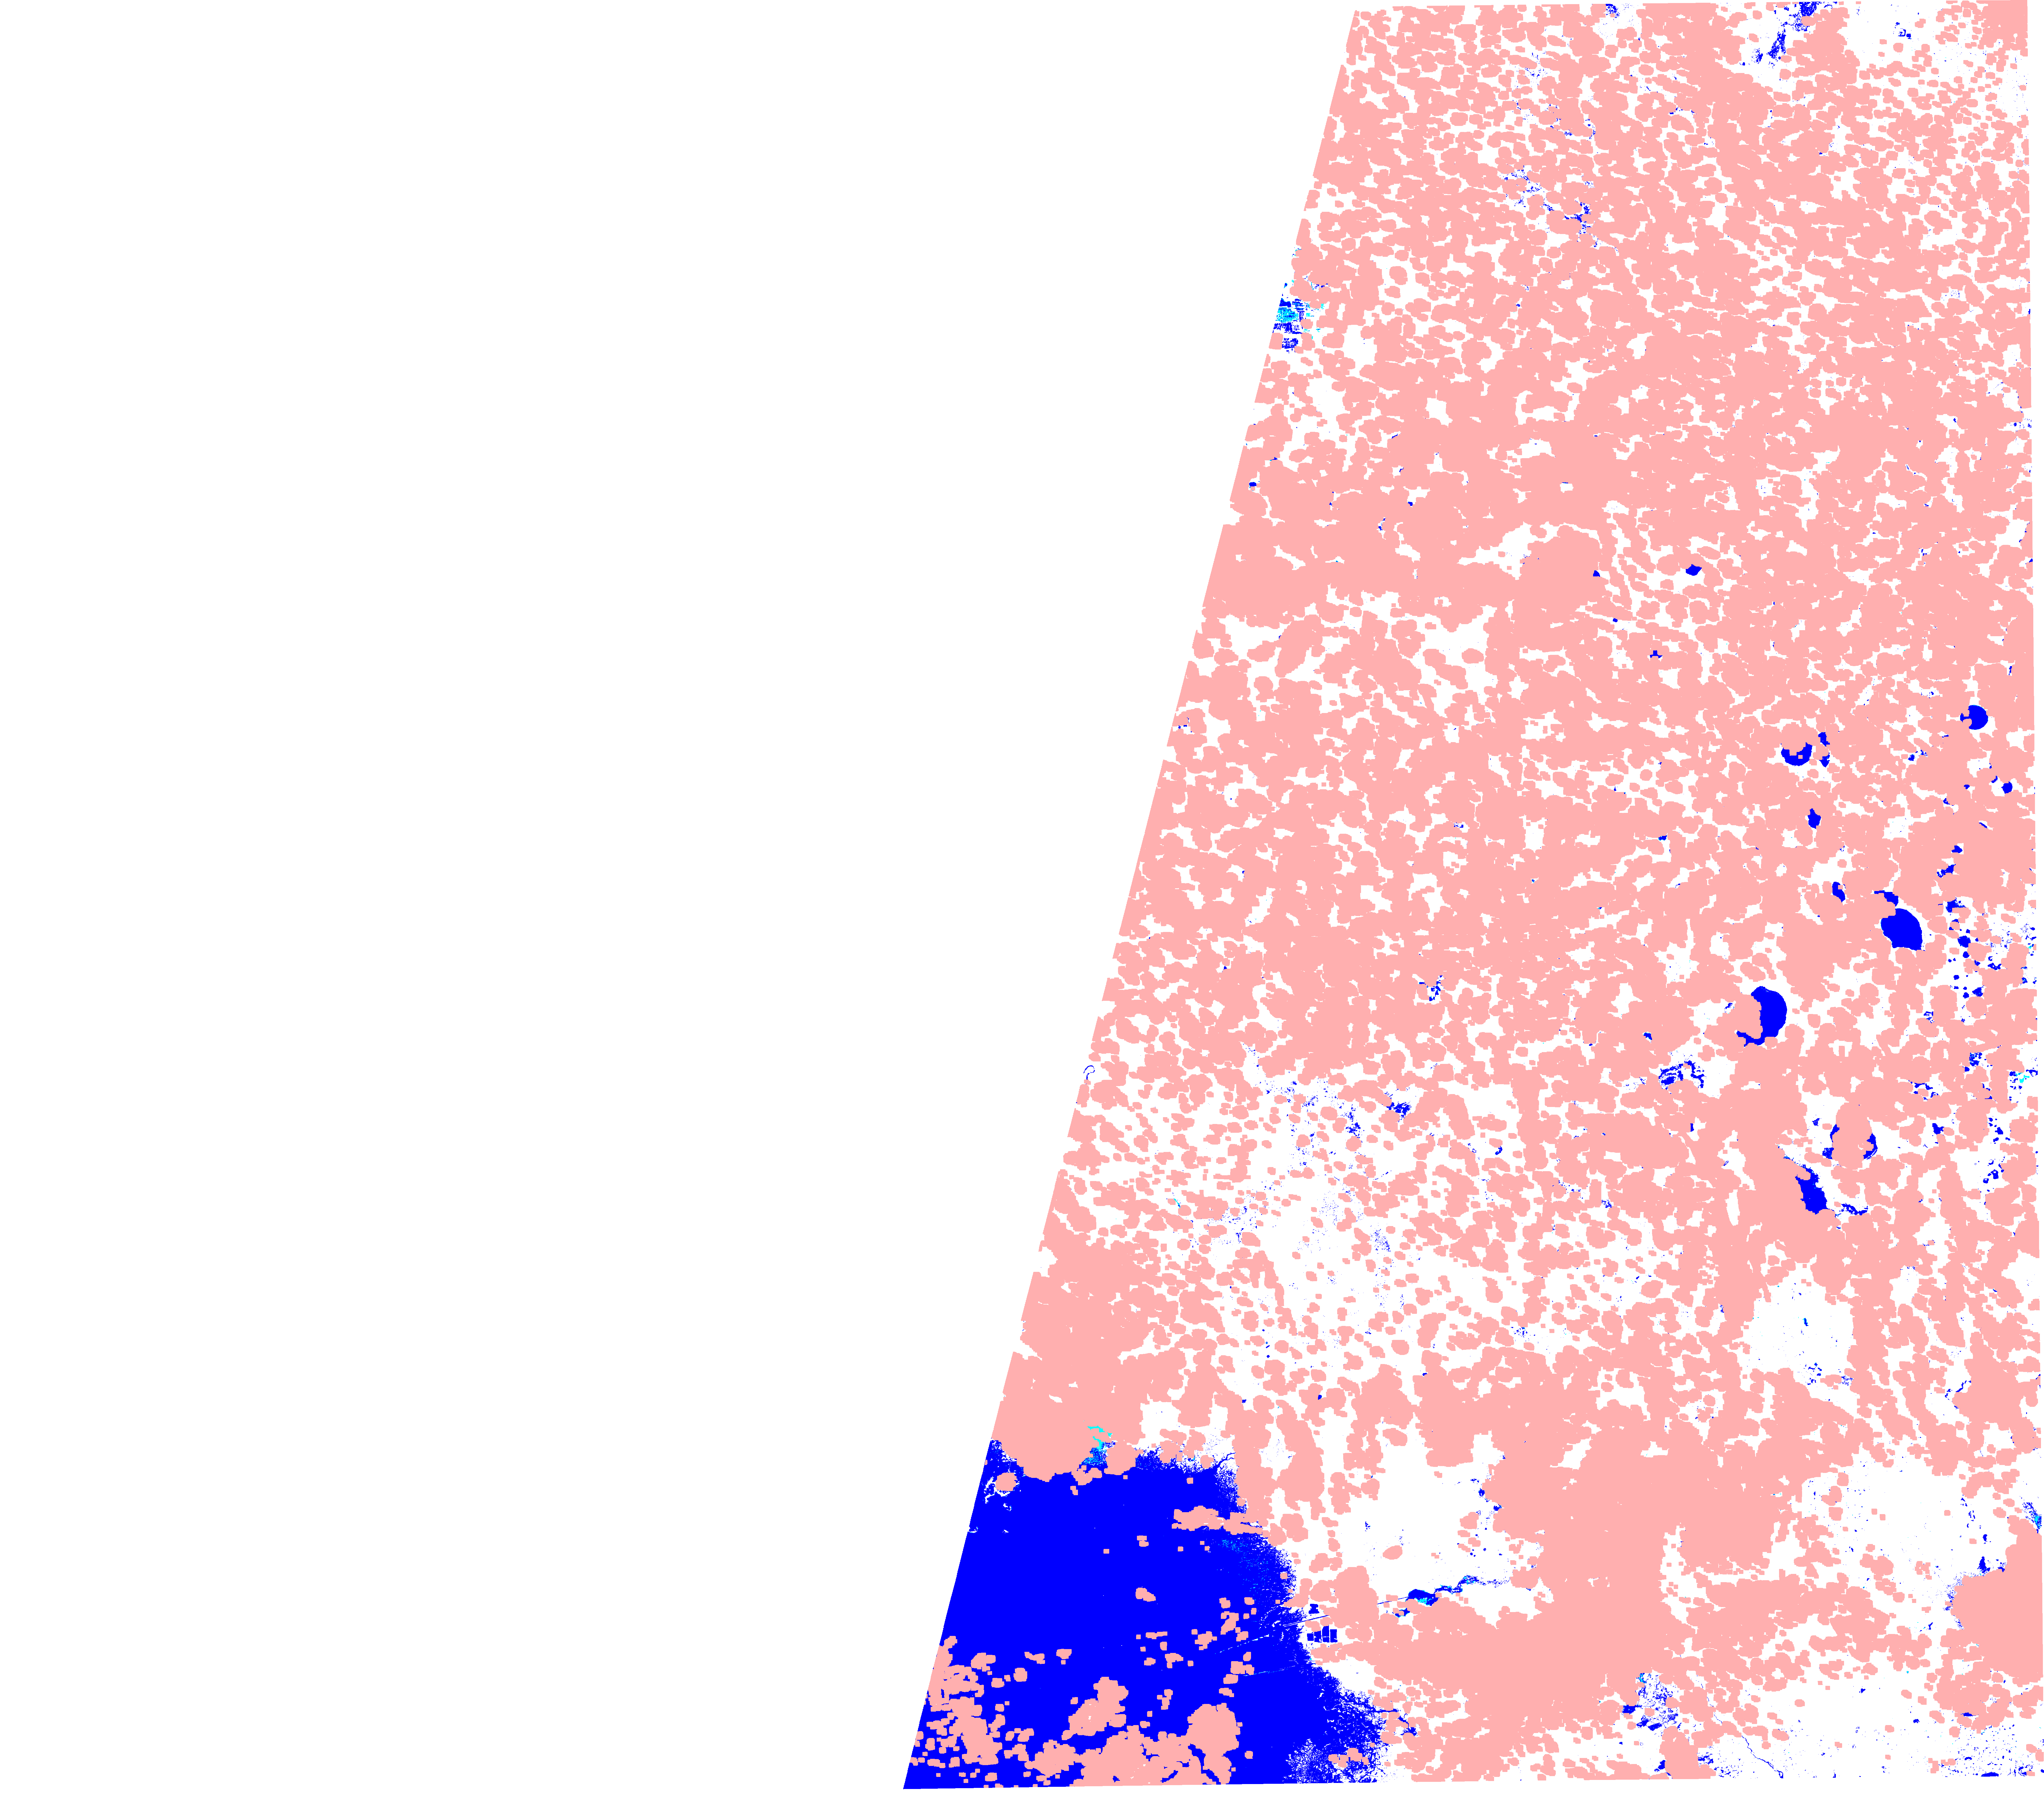
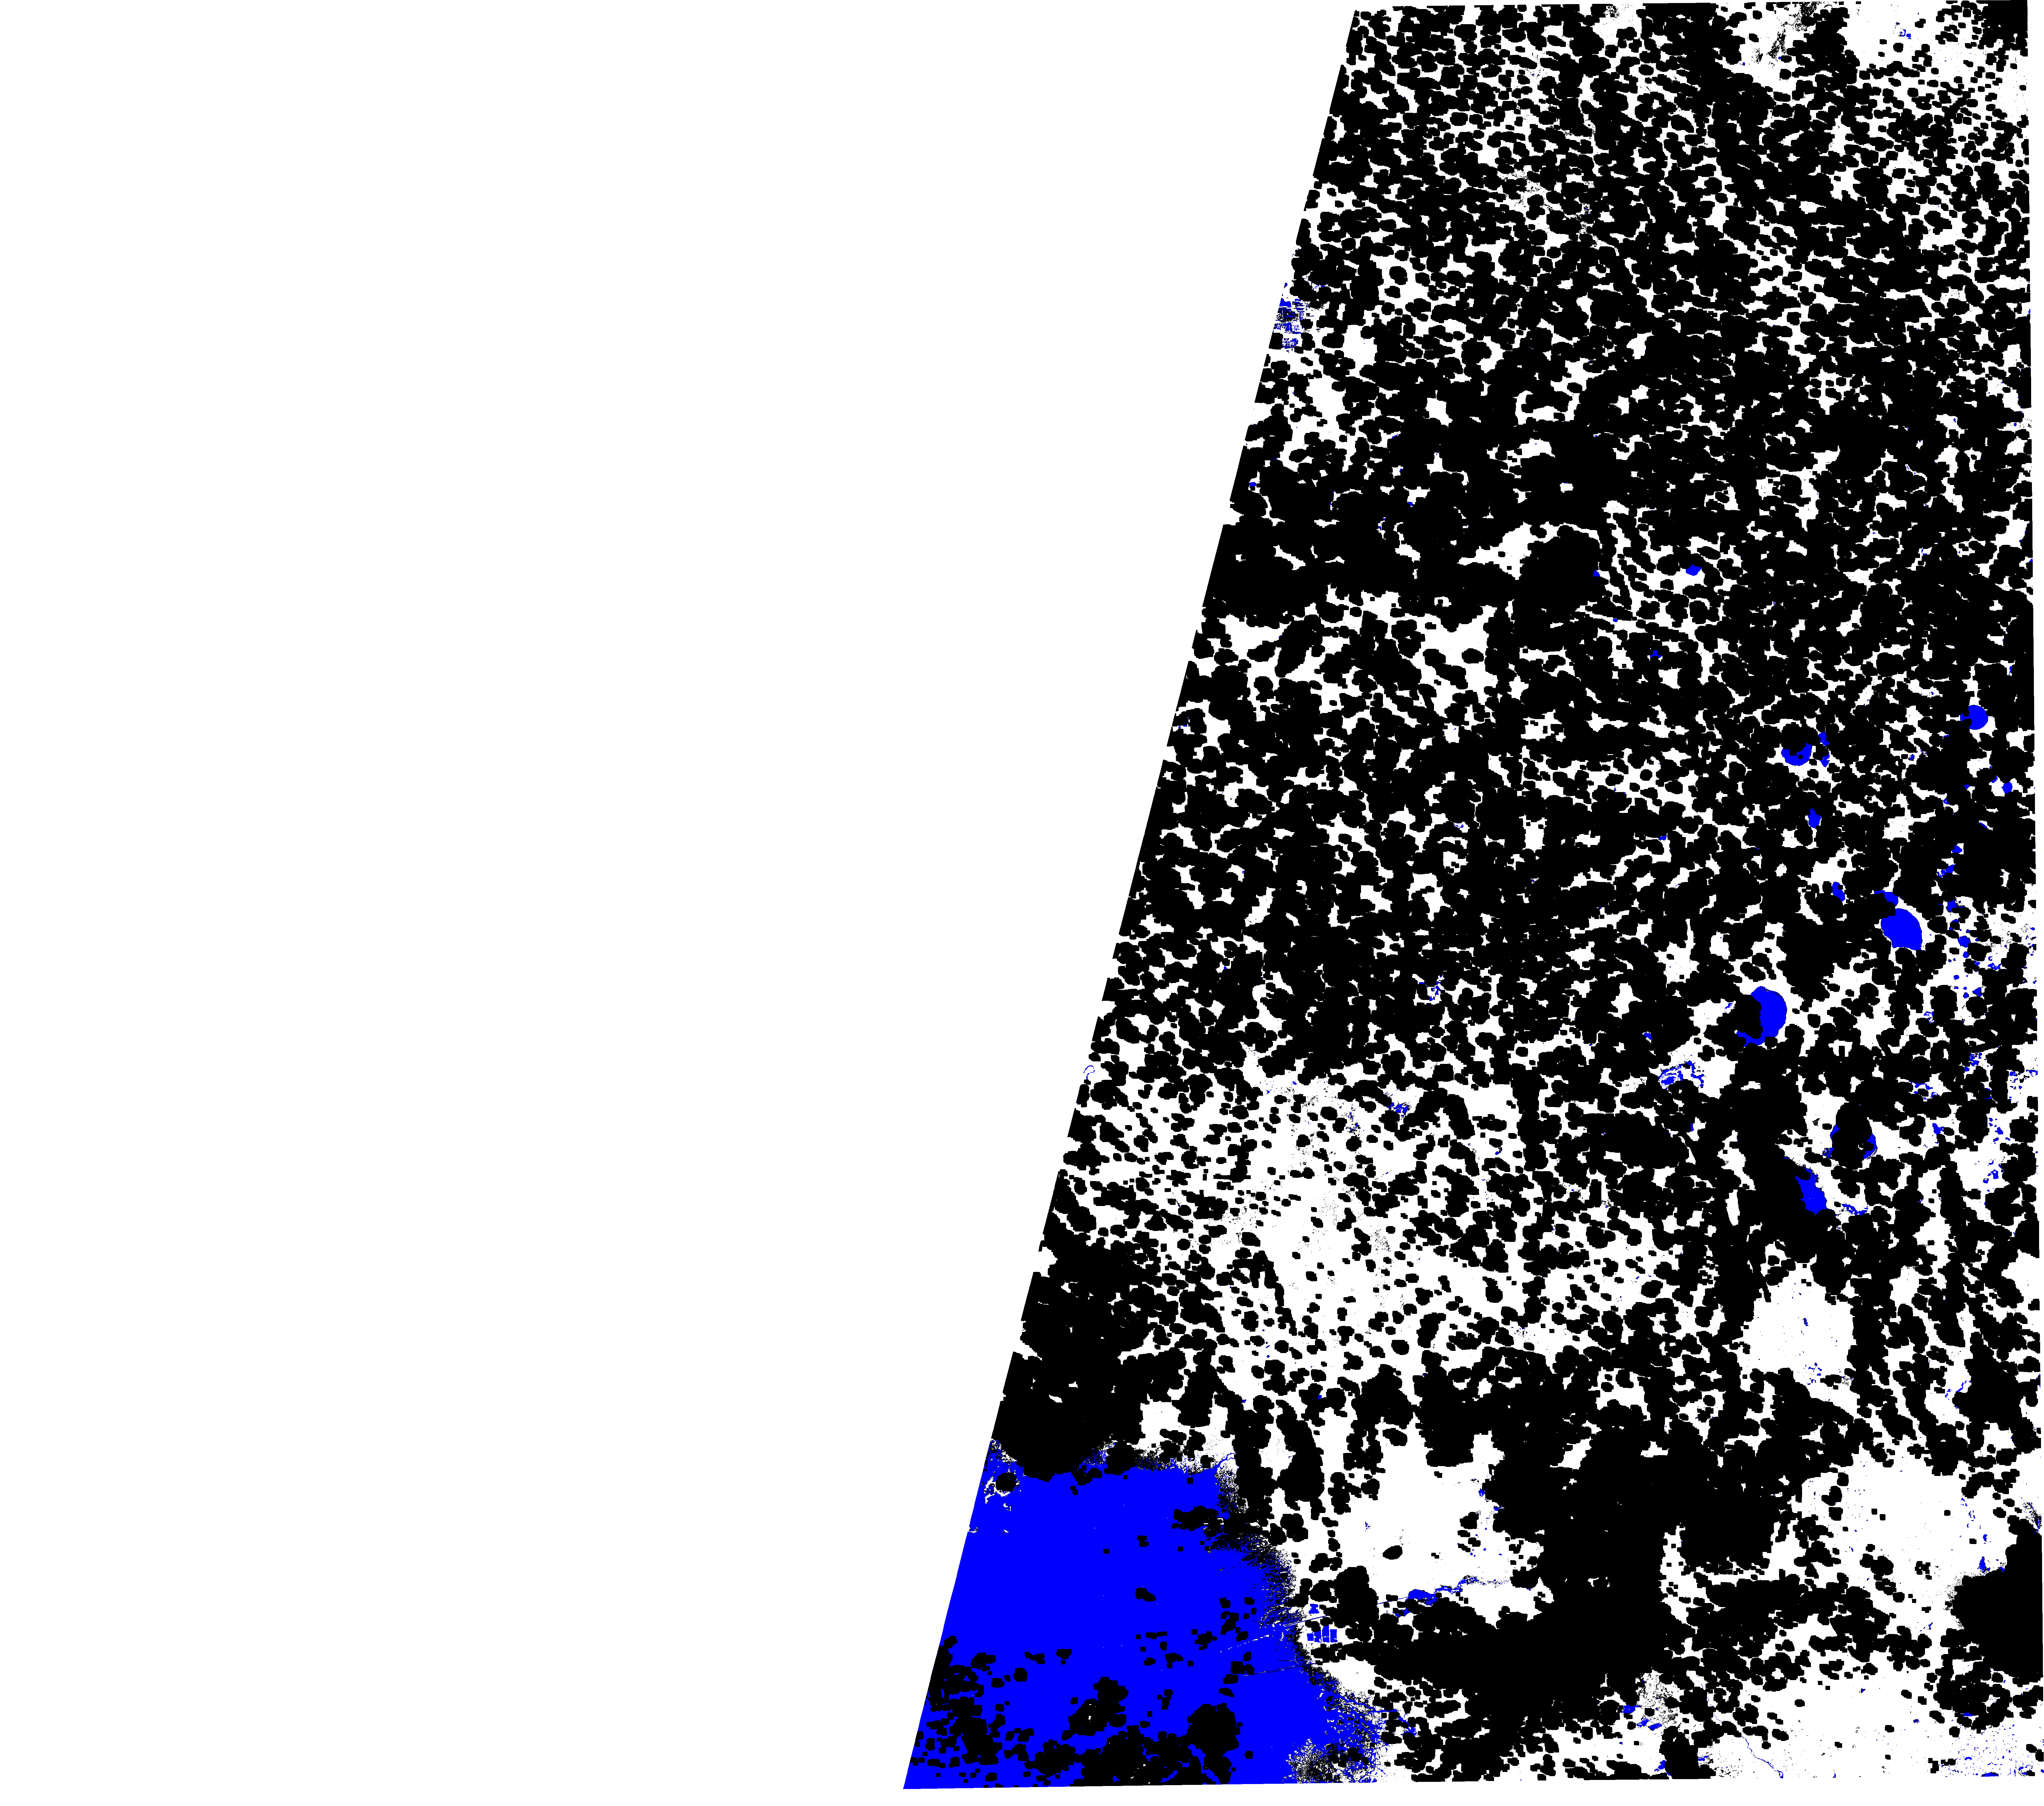

In [16]:
# Initialize Folium basemap
xmid =(merged_B02.x.values.min()+merged_B02.x.values.max())/2 ; ymid = (merged_B02.y.values.min()+merged_B02.y.values.max())/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='CartoDB positron', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay B02 and B03 layers
folium.raster_layers.ImageOverlay(colored_B02, 
                                        opacity=0.6, 
                                        bounds=[[merged_B02.y.values.min(),merged_B02.x.values.min()],[merged_B02.y.values.max(),merged_B02.x.values.max()]],
                                        name='Flooded Area',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colored_B03, 
                                        opacity=0.8, 
                                        bounds=[[merged_B03.y.values.min(),merged_B03.x.values.min()],[merged_B03.y.values.max(),merged_B03.x.values.max()]],
                                        name='Confidence Layer', 
                                        show=False).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m